<a href="https://colab.research.google.com/github/Sindhuhar/deep_learning/blob/main/first_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A gentle guide to training your first CNN with Keras and TensorFlow

### Download the code zip file

In [21]:
!wget https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/first-cnn/first-cnn.zip
!unzip -qq first-cnn.zip
%cd first-cnn
!wget https://pis-datasets.s3.us-east-2.amazonaws.com/animals.zip
!unzip -qq animals.zip

--2023-11-08 07:10:45--  https://pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com/first-cnn/first-cnn.zip
Resolving pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)... 52.92.163.234, 52.92.192.202, 52.92.148.42, ...
Connecting to pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com (pyimagesearch-code-downloads.s3-us-west-2.amazonaws.com)|52.92.163.234|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10378 (10K) [binary/octet-stream]
Saving to: ‘first-cnn.zip’

first-cnn.zip       100%[===================>]  10.13K  --.-KB/s    in 0s      

2023-11-08 07:10:45 (88.7 MB/s) - ‘first-cnn.zip’ saved [10378/10378]

/content/first-cnn/first-cnn/first-cnn
--2023-11-08 07:10:45--  https://pis-datasets.s3.us-east-2.amazonaws.com/animals.zip
Resolving pis-datasets.s3.us-east-2.amazonaws.com (pis-datasets.s3.us-east-2.amazonaws.com)... 3.5.132.13, 52.219.101.42, 52.219.96.48, ...
Connecting to pis-

### Import Packages

In [2]:
# import the necessary packages
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pyimagesearch.preprocessing import ImageToArrayPreprocessor
from pyimagesearch.preprocessing import SimplePreprocessor
from pyimagesearch.datasets import SimpleDatasetLoader
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import cifar10
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np

### Implementing ShallowNet


In [3]:
class ShallowNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last"
		model = Sequential()
		inputShape = (height, width, depth)

		# if we are using "channels first", update the input shape
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)

		# define the first (and only) CONV => RELU layer
		model.add(Conv2D(32, (3, 3), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))

		# softmax classifier
		model.add(Flatten())
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

### ShallowNet on Animals

In [4]:
# grab the list of images that we'll be describing
print("[INFO] loading images...")
imagePaths = list(paths.list_images("animals"))

[INFO] loading images...


In [5]:
# initialize the image preprocessors
sp = SimplePreprocessor(32, 32)
iap = ImageToArrayPreprocessor()

# load the dataset from disk then scale the raw pixel intensities
# to the range [0, 1]
sdl = SimpleDatasetLoader(preprocessors=[sp, iap])
(data, labels) = sdl.load(imagePaths, verbose=500)
data = data.astype("float") / 255.0

[INFO] processed 500/3000
[INFO] processed 1000/3000
[INFO] processed 1500/3000
[INFO] processed 2000/3000
[INFO] processed 2500/3000
[INFO] processed 3000/3000


In [6]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, random_state=42)

# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

In [7]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.005)
model = ShallowNet.build(width=32, height=32, depth=3, classes=3)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
	batch_size=32, epochs=100, verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/100
71/71 [==============================] - 3s 32ms/step - loss: 0.9913 - accuracy: 0.5027 - val_loss: 0.9186 - val_accuracy: 0.5333
Epoch 2/100
71/71 [==============================] - 2s 28ms/step - loss: 0.8986 - accuracy: 0.5533 - val_loss: 1.0626 - val_accuracy: 0.4720
Epoch 3/100
71/71 [==============================] - 2s 27ms/step - loss: 0.8569 - accuracy: 0.5747 - val_loss: 0.8966 - val_accuracy: 0.5373
Epoch 4/100
71/71 [==============================] - 2s 27ms/step - loss: 0.8177 - accuracy: 0.5982 - val_loss: 0.8414 - val_accuracy: 0.5693
Epoch 5/100
71/71 [==============================] - 3s 48ms/step - loss: 0.8231 - accuracy: 0.6036 - val_loss: 0.8385 - val_accuracy: 0.5627
Epoch 6/100
71/71 [==============================] - 3s 48ms/step - loss: 0.7979 - accuracy: 0.6098 - val_loss: 0.8356 - val_accuracy: 0.5720
Epoch 7/100
71/71 [==============================] - 2s 33ms/step - loss: 0.7759 - accuracy: 0.

In [8]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1),
	target_names=["cat", "dog", "panda"]))

[INFO] evaluating network...
24/24 [==============================] - 0s 10ms/step
              precision    recall  f1-score   support

         cat       0.62      0.71      0.66       262
         dog       0.63      0.43      0.51       249
       panda       0.77      0.90      0.83       239

    accuracy                           0.68       750
   macro avg       0.67      0.68      0.67       750
weighted avg       0.67      0.68      0.66       750



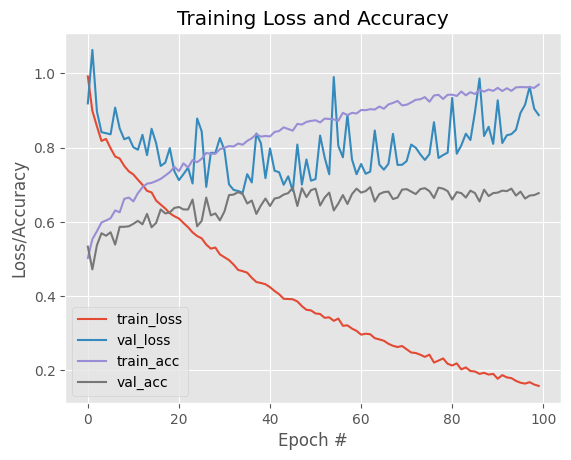

In [9]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [10]:
# load the training and testing data, then scale it into the
# range [0, 1]
print("[INFO] loading CIFAR-10 data...")
((trainX, trainY), (testX, testY)) = cifar10.load_data()
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0

# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)

# initialize the label names for the CIFAR-10 dataset
labelNames = ["airplane", "automobile", "bird", "cat", "deer",
	"dog", "frog", "horse", "ship", "truck"]

[INFO] loading CIFAR-10 data...
170498071/170498071 [==============================] - 2s 0us/step


In [11]:
# initialize the optimizer and model
print("[INFO] compiling model...")
opt = SGD(lr=0.01)
model = ShallowNet.build(width=32, height=32, depth=3, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the network
print("[INFO] training network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY),
	batch_size=32, epochs=40, verbose=1)

[INFO] compiling model...
[INFO] training network...
Epoch 1/40
1563/1563 [==============================] - 56s 36ms/step - loss: 1.8072 - accuracy: 0.3660 - val_loss: 1.6858 - val_accuracy: 0.4018
Epoch 2/40
1563/1563 [==============================] - 49s 32ms/step - loss: 1.5730 - accuracy: 0.4528 - val_loss: 1.5497 - val_accuracy: 0.4418
Epoch 3/40
1563/1563 [==============================] - 47s 30ms/step - loss: 1.4324 - accuracy: 0.4981 - val_loss: 1.4149 - val_accuracy: 0.4923
Epoch 4/40
1563/1563 [==============================] - 54s 35ms/step - loss: 1.3436 - accuracy: 0.5299 - val_loss: 1.3473 - val_accuracy: 0.5213
Epoch 5/40
1563/1563 [==============================] - 52s 33ms/step - loss: 1.2852 - accuracy: 0.5499 - val_loss: 1.3185 - val_accuracy: 0.5267
Epoch 6/40
1563/1563 [==============================] - 49s 31ms/step - loss: 1.2419 - accuracy: 0.5673 - val_loss: 1.3529 - val_accuracy: 0.5170
Epoch 7/40
1563/1563 [==============================] - 49s 31ms/step -

In [12]:
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

[INFO] evaluating network...
313/313 [==============================] - 3s 11ms/step
              precision    recall  f1-score   support

    airplane       0.61      0.64      0.63      1000
  automobile       0.76      0.68      0.72      1000
        bird       0.32      0.65      0.43      1000
         cat       0.49      0.31      0.38      1000
        deer       0.61      0.34      0.44      1000
         dog       0.51      0.47      0.49      1000
        frog       0.63      0.71      0.67      1000
       horse       0.69      0.65      0.67      1000
        ship       0.79      0.63      0.70      1000
       truck       0.65      0.67      0.66      1000

    accuracy                           0.58     10000
   macro avg       0.61      0.58      0.58     10000
weighted avg       0.61      0.58      0.58     10000



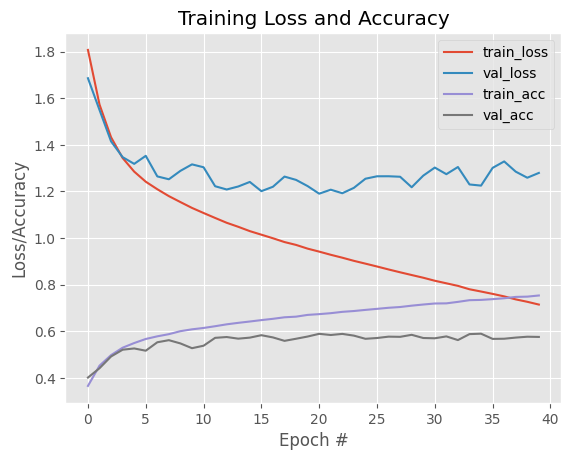

In [13]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 40), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 40), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 40), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 40), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()